### Basic character-level sequence-to-sequence translation using LSTM Encoder and Decoder architecture. 

This activity is based on the keras example and it demonstrates how to implement a basic character-level recurrent sequence-to-sequence model. It is applied to translate short English sentences into short French sentences, character-by-character. 

__Note__ that it is fairly unusual to do character-level machine translation, as word-level models are more common in this domain.

Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set the appropriate path

In [ ]:
import os
os.chdir("/content/drive/My Drive ")

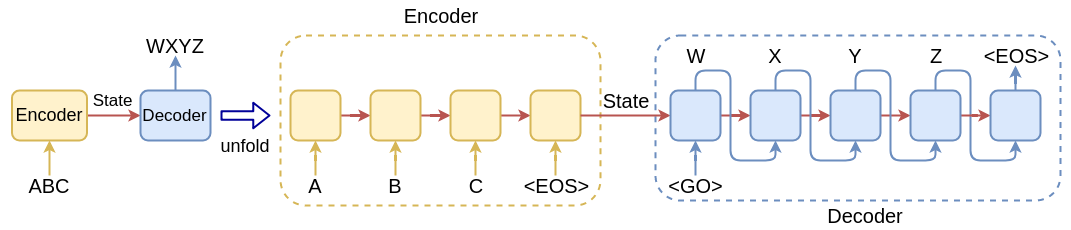

In [ ]:
 from IPython.display import Image
Image("seq2seq.png")


print("vinay typed bymistake")

Import required modules

In [ ]:
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.utils import plot_model

Define the configuration variables

In [ ]:
batch_size = 64                # Batch size for training.
epochs = 100                   # Number of epochs to train for.
latent_dim = 256               # Latent dimensionality of the encoding space.
num_samples = 10000            # Number of samples to train on.
data_path = 'fra_eng.txt'      # Path to the data txt file on disk.

#### Vectorize the data.

In [ ]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

Reading the data file

In [ ]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [ ]:
len(lines)

154884

Getting input data and target data

In [ ]:
for line in lines[: min(num_samples, len(lines) - 1)]:

    input_text, target_text = line.split('\t')
    
    # We use "tab" i.e. "\t" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    # These appended french sentences will be used as inputs to decoder.
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [ ]:
print(len(input_characters))
print(len(target_characters))

71
94


In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [ ]:
print(input_token_index)

{' ': 0, '!': 1, '$': 2, '%': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, '?': 20, 'A': 21, 'B': 22, 'C': 23, 'D': 24, 'E': 25, 'F': 26, 'G': 27, 'H': 28, 'I': 29, 'J': 30, 'K': 31, 'L': 32, 'M': 33, 'N': 34, 'O': 35, 'P': 36, 'Q': 37, 'R': 38, 'S': 39, 'T': 40, 'U': 41, 'V': 42, 'W': 43, 'Y': 44, 'a': 45, 'b': 46, 'c': 47, 'd': 48, 'e': 49, 'f': 50, 'g': 51, 'h': 52, 'i': 53, 'j': 54, 'k': 55, 'l': 56, 'm': 57, 'n': 58, 'o': 59, 'p': 60, 'q': 61, 'r': 62, 's': 63, 't': 64, 'u': 65, 'v': 66, 'w': 67, 'x': 68, 'y': 69, 'z': 70}


In [ ]:
print(target_token_index)

{'\t': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, ',': 10, '-': 11, '.': 12, '0': 13, '1': 14, '3': 15, '5': 16, '6': 17, '8': 18, '9': 19, ':': 20, '?': 21, 'A': 22, 'B': 23, 'C': 24, 'D': 25, 'E': 26, 'F': 27, 'G': 28, 'H': 29, 'I': 30, 'J': 31, 'K': 32, 'L': 33, 'M': 34, 'N': 35, 'O': 36, 'P': 37, 'Q': 38, 'R': 39, 'S': 40, 'T': 41, 'U': 42, 'V': 43, 'Y': 44, 'a': 45, 'b': 46, 'c': 47, 'd': 48, 'e': 49, 'f': 50, 'g': 51, 'h': 52, 'i': 53, 'j': 54, 'k': 55, 'l': 56, 'm': 57, 'n': 58, 'o': 59, 'p': 60, 'q': 61, 'r': 62, 's': 63, 't': 64, 'u': 65, 'v': 66, 'w': 67, 'x': 68, 'y': 69, 'z': 70, '\xa0': 71, '«': 72, '»': 73, 'À': 74, 'Ç': 75, 'É': 76, 'Ê': 77, 'à': 78, 'â': 79, 'ç': 80, 'è': 81, 'é': 82, 'ê': 83, 'ë': 84, 'î': 85, 'ï': 86, 'ô': 87, 'ù': 88, 'û': 89, 'œ': 90, '\u2009': 91, '’': 92, '\u202f': 93}


In [ ]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
print(reverse_input_char_index)

{0: ' ', 1: '!', 2: '$', 3: '%', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '0', 10: '1', 11: '2', 12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8', 18: '9', 19: ':', 20: '?', 21: 'A', 22: 'B', 23: 'C', 24: 'D', 25: 'E', 26: 'F', 27: 'G', 28: 'H', 29: 'I', 30: 'J', 31: 'K', 32: 'L', 33: 'M', 34: 'N', 35: 'O', 36: 'P', 37: 'Q', 38: 'R', 39: 'S', 40: 'T', 41: 'U', 42: 'V', 43: 'W', 44: 'Y', 45: 'a', 46: 'b', 47: 'c', 48: 'd', 49: 'e', 50: 'f', 51: 'g', 52: 'h', 53: 'i', 54: 'j', 55: 'k', 56: 'l', 57: 'm', 58: 'n', 59: 'o', 60: 'p', 61: 'q', 62: 'r', 63: 's', 64: 't', 65: 'u', 66: 'v', 67: 'w', 68: 'x', 69: 'y', 70: 'z'}


In [ ]:
len(input_texts)

10000

Place holders to create one-hot representation

In [ ]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [ ]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(10000, 16, 71)
(10000, 59, 94)
(10000, 59, 94)


Create one-hot character embeddings for English and French sentences. These will be the inputs to the encoder and the decoder. The French one-hot character embeds will also be used as target data for loss function.

The embeds (encoder_input_data and decoder_input_data and decoder_target_data) are 3D arrays. The first dimension corresponds to num_samples (10,000 in this case). The second dimension corresponds to the maximum length of english / french sentence and the third dimension corresponds to total number of english / french characters.

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

* Feed character by character embeds into the encoder till the end of the English sentence sequence.
* Obtain the final encoder states (hidden and cell states) and feed them into the decoder as its initial state.
* Decoder will have 3 inputs at every time step 
  - 2 decoder states and 
  - The French character embeds fed to it character by character.
* At every step of the decoder, the output of the decoder is sent to softmax layer that is compared with the target data.

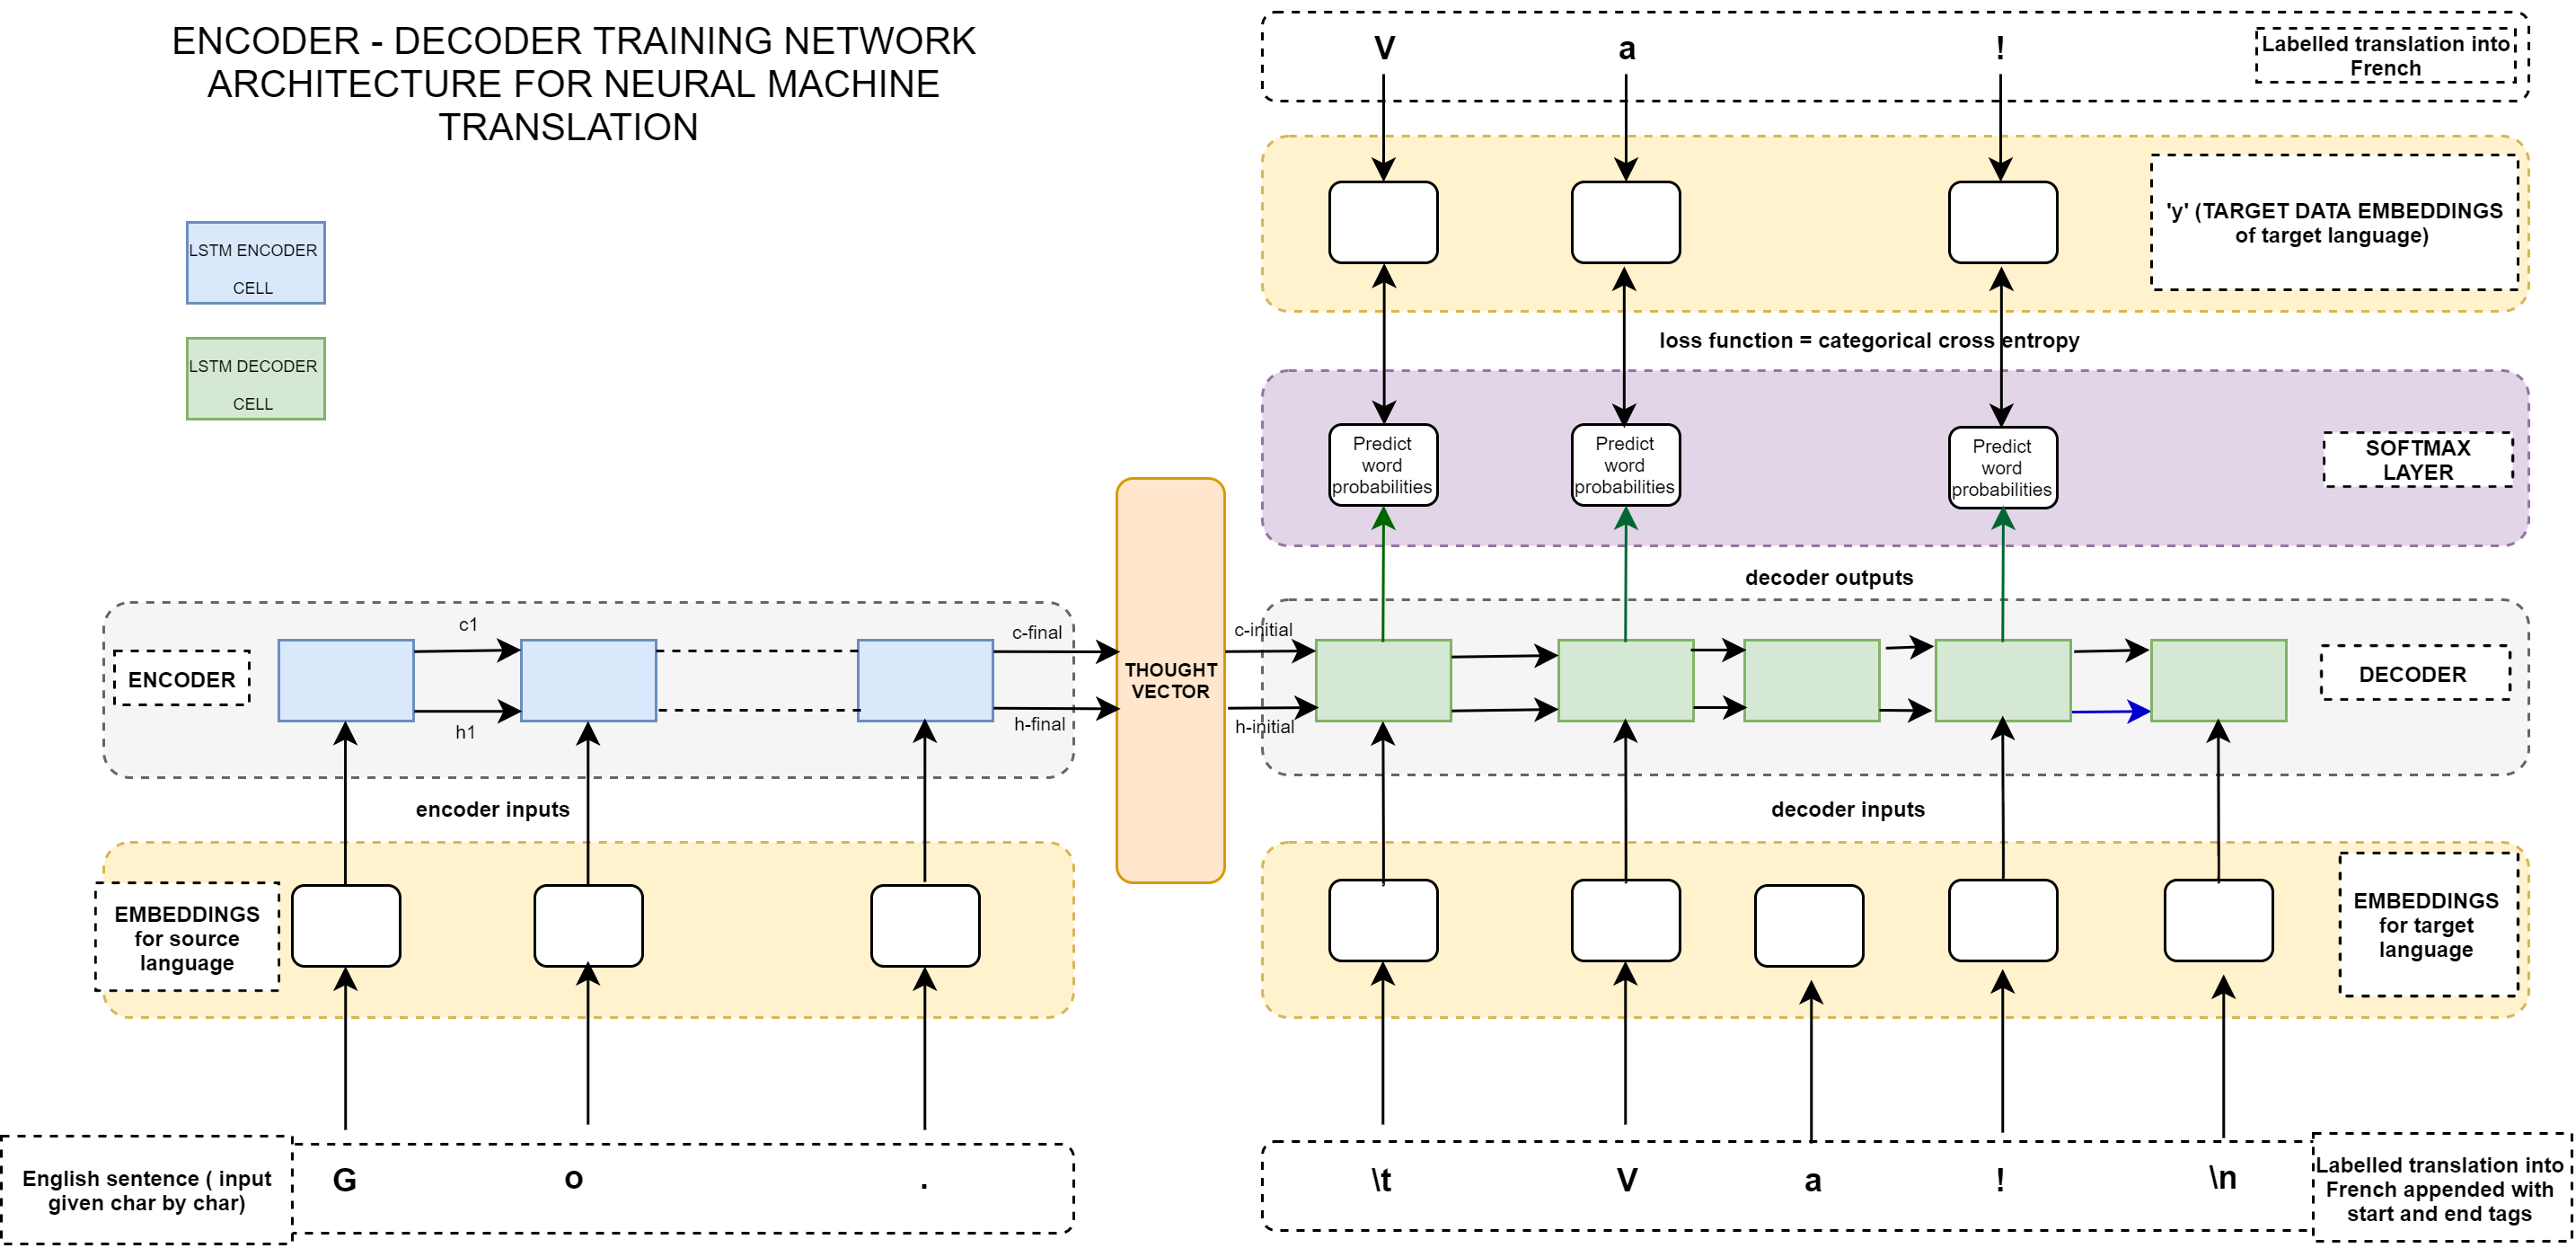

In [ ]:
Image("Seq2SeqTrainingNet.png")

In [ ]:
# Define an input sequence and process it.


# Input shape is specified as (None, num_encoder_tokens). This means the 
# encoder LSTM can dynamically unroll that many timesteps as the number 
# of characters till it reaches the end of sequence for that sentence.
encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_input')
encoder = LSTM(latent_dim, return_state=True, name='encoder_lstm')

# For encoder LSTM, return_state is set to True and return_sequences is set 
# to False (default). This would mean that we obtain only the final encoded 
# cell state and the encoded hidden state at the end of the input sequence and 
# not the intermediate states at every time step. These will be the final 
# encoded states that are used to initialize the state of the decoder.
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_input')

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

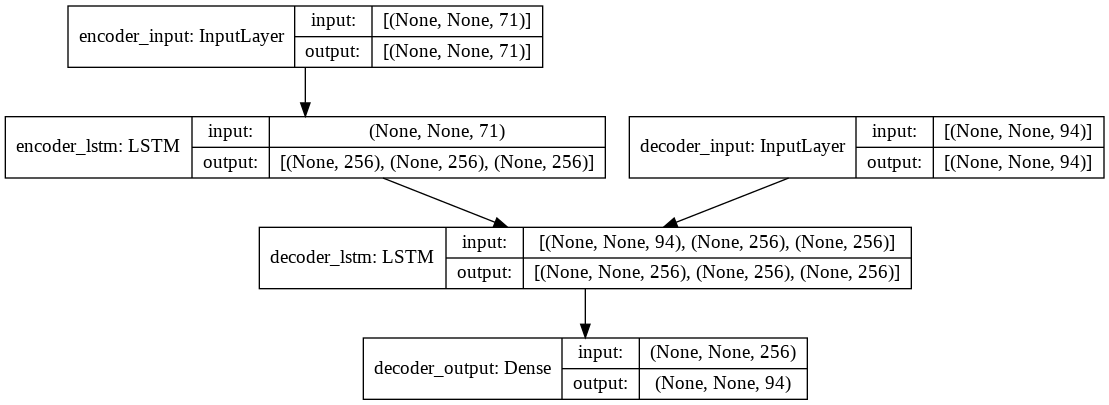

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs,
          validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 54s 405ms/step - loss: 1.0367 - val_loss: 1.1672
Epoch 2/100
125/125 [==============================] - 48s 382ms/step - loss: 0.9655 - val_loss: 1.1434
Epoch 3/100
125/125 [==============================] - 48s 387ms/step - loss: 0.9107 - val_loss: 1.0677
Epoch 4/100
125/125 [==============================] - 48s 387ms/step - loss: 0.8696 - val_loss: 1.0308
Epoch 5/100
125/125 [==============================] - 50s 399ms/step - loss: 0.8358 - val_loss: 0.9595
Epoch 6/100
125/125 [==============================] - 48s 386ms/step - loss: 0.8063 - val_loss: 0.9721
Epoch 7/100
125/125 [==============================] - 48s 384ms/step - loss: 0.7797 - val_loss: 0.9093
Epoch 8/100
125/125 [==============================] - 49s 389ms/step - loss: 0.7574 - val_loss: 0.9753
Epoch 9/100
125/125 [==============================] - 49s 389ms/step - loss: 0.7365 - val_loss: 0.9019
Epoch 10/100
125/125 [==============================] - 48s 386m

## Inference mode

To decode a test sentence, we will repeatedly:

1. Encode the input sentence and retrieve the initial decoder state
2. Run one step of the decoder with this initial state and a "start of sequence" token as target. The output will be the next target character.
3. Append the target character predicted and repeat.



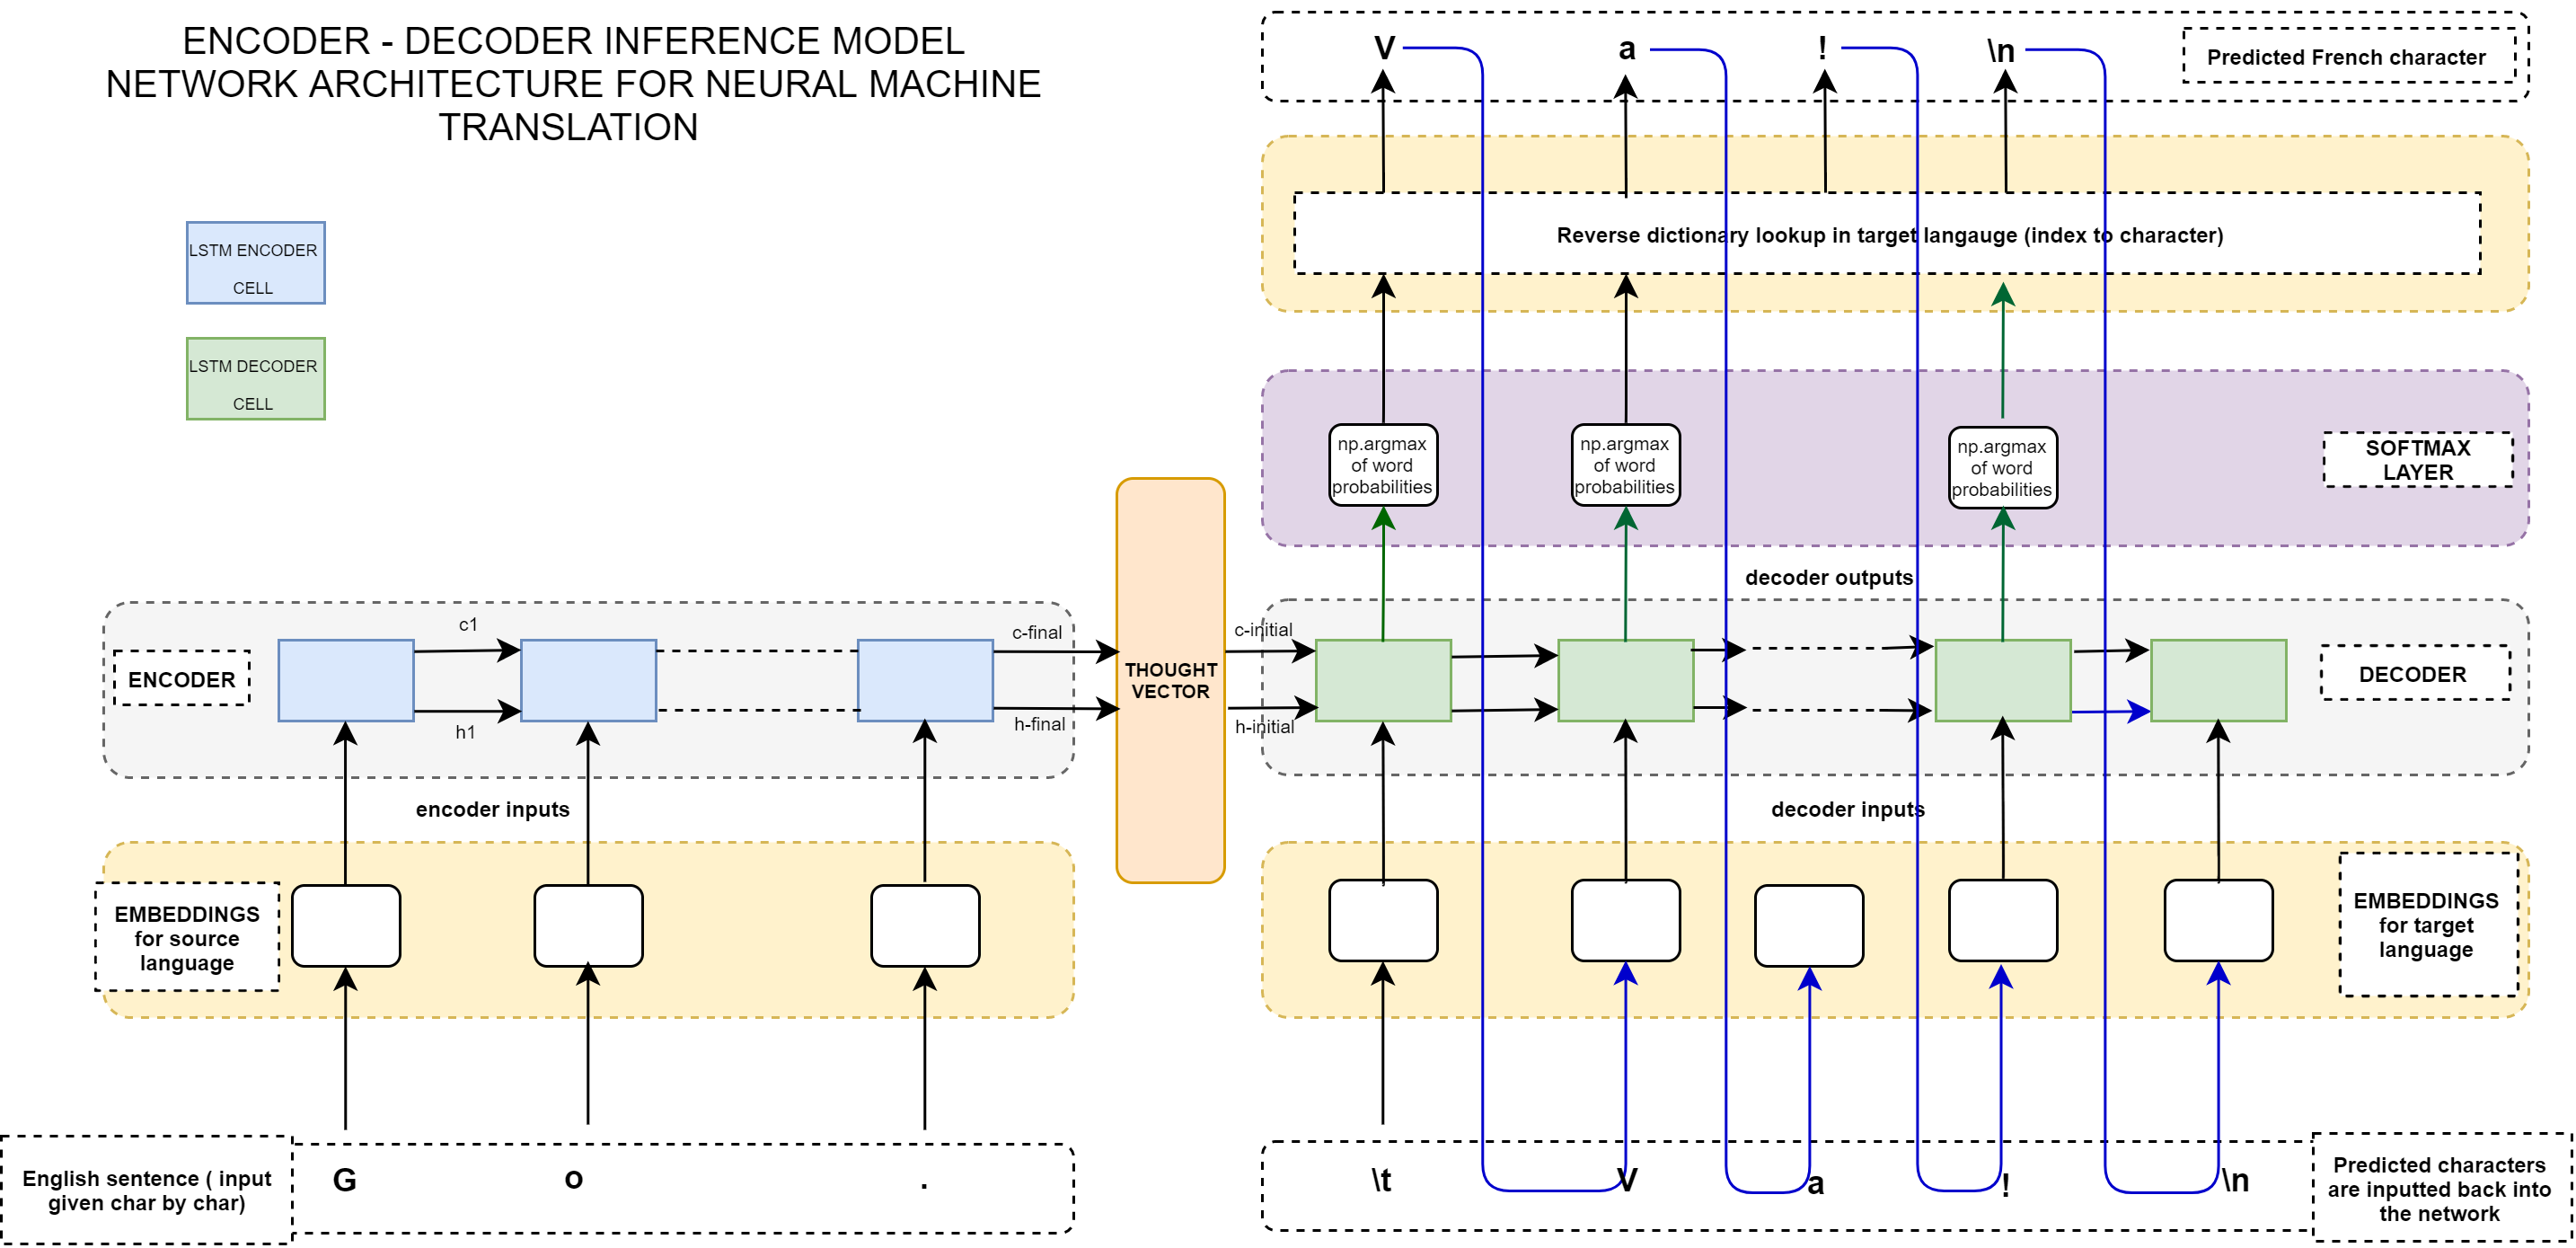

In [ ]:
Image("Seq2SeqInferenceModel.png") 

In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

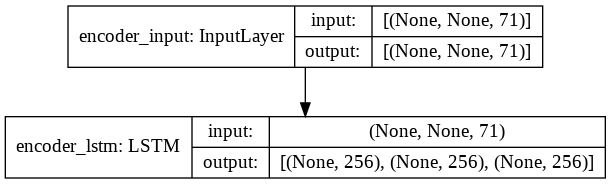

In [ ]:
plot_model(encoder_model, show_shapes=True)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, None, 71)]        0         
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 256), (None, 256) 335872    
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_input')
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] 

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

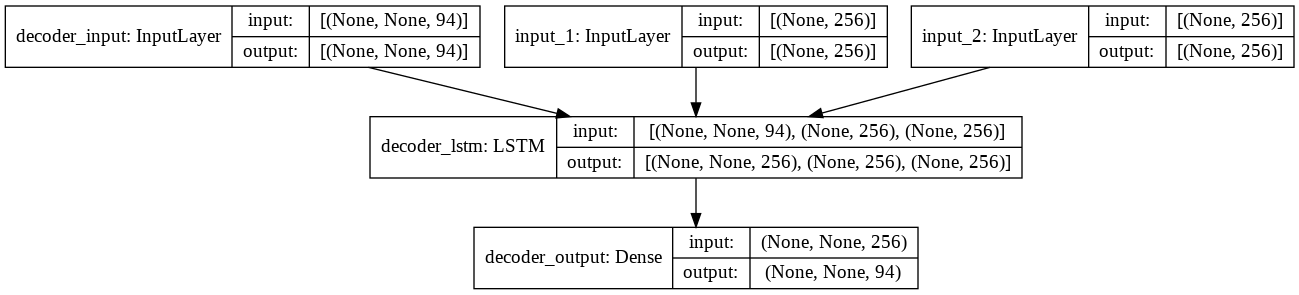

In [ ]:
plot_model(decoder_model, show_shapes=True)

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None, 94)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  359424      decoder_input[0][0]              
                                                                 input_1[0][0]              

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # predict a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(100):
    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Pa  eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
-
Input sentence: Run!
Decoded sentence: Coures.

-
Input sentence: Run!
Decoded sentence: Coures.

-
Input sentence: Fire!
Decoded sentence: Pe les e.

-
Input sentence: Help!
Decoded sentence: Sour e.

-
Input sentence: Jump.
Decoded sentence: Coures.

-
Input sentence: Stop!
Decoded sentence: Arrête dous la mais en.

-
Input sentence: Stop!
Decoded sentence: Arrête dous la mais en.

-
Input sentence: Stop!
Decoded sentence: Arrête dous la mais en.

-
Input sentence: Wait!
Decoded sentence: Attende .

-
Input sentence: Wait!
Decoded sentence: Attende .

-
Input sentence: Go on.
Decoded sentence: Poursui .

-
Input sentence: Go on.
Decoded sentence: Poursui .

-
Input sentence: Go on.
Decoded sentence: Poursui .

-
Input sentence: I see.
Decoded sentence: Je me suis parte.

-
Input sentence: I try.
Decoded sentence: J'ess pare.

-
Input sentence: I won!
Decoded sentence: Je l'ai contra

## Algorithm summary
 

* We start with input sequences from a domain (e.g. English sentences) and corresponding target sequences from another domain (e.g. French sentences).
An encoder LSTM turns input sequences to 2 state vectors (we keep the last LSTM state and discard the outputs).
* A decoder LSTM is trained to turn the target sequences into the same sequence but offset by one timestep in the future, a training process called __teacher forcing__ in this context. It uses as initial state the state vectors from the encoder. Effectively, the decoder learns to generate targets `[t+1...]` given targets `[...t]`, conditioned on the input sequence.
* In inference mode, when we want to decode unknown input sequences: 
  - Encode the input sequence into state vectors 
  - Start with a target sequence of size 1 (just the start-of-sequence character) 
  - Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character 
  - Sample the next character using these predictions (we simply use argmax). 
  - Append the sampled character to the target sequence 
  - Repeat until we generate the end-of-sequence character or we hit the character limit.

## References:

* https://keras.io/examples/nlp/lstm_seq2seq/
* https://towardsdatascience.com/neural-machine-translation-using-seq2seq-with-keras-c23540453c74